In [50]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [51]:
# Load the datasets
train_df = pd.read_csv("my_train.csv")
validation_df = pd.read_csv("my_dev.csv")
test_df = pd.read_csv("test.csv")

# Separate features (X) and target (y)
X_train = train_df.drop(columns=["Id", "SalePrice"])
y_train_log = np.log(train_df["SalePrice"])  # Apply log transformation to the target variable
X_val = validation_df.drop(columns=["Id", "SalePrice"])
y_val = validation_df["SalePrice"]  # Keep the validation target in the original scale
X_test = test_df.drop(columns=["Id"])

# Identify numerical and categorical columns
cat_features = X_train.select_dtypes(include=['object']).columns
num_features = X_train.select_dtypes(exclude=['object']).columns

In [46]:
# Update the pipeline to use Ridge regression
ridge_pipeline = Pipeline(steps=[
    ("preprocessing", preprocess_pipeline),
    ("ridge_model", Ridge())
])

# Define a grid of alpha values for tuning
param_grid = {"ridge_model__alpha": [0.01, 0.1, 1, 10, 100]}

# Perform grid search
ridge_search = GridSearchCV(ridge_pipeline, param_grid, scoring="neg_mean_squared_log_error", cv=5)
ridge_search.fit(X_train, y_train_log)

# Best alpha value
best_alpha = ridge_search.best_params_["ridge_model__alpha"]
print(f"Best alpha for Ridge regression: {best_alpha}")

# Train final Ridge model with best alpha
ridge_pipeline.set_params(ridge_model__alpha=best_alpha)
ridge_pipeline.fit(X_train, y_train_log)

# Validate on the development set
y_val_pred_log_ridge = ridge_pipeline.predict(X_val)
y_val_pred_ridge = np.exp(y_val_pred_log_ridge)
rmsle_val_ridge = np.sqrt(mean_squared_log_error(y_val, y_val_pred_ridge))
print(f"RMSLE on validation set with Ridge regression: {rmsle_val_ridge}")

# Final training with the best pipeline (e.g., Ridge or Polynomial)
ridge_pipeline.fit(pd.concat([X_train, X_val]), np.log(pd.concat([train_df["SalePrice"], validation_df["SalePrice"]])))

# Generate test predictions
y_test_pred_log_best = ridge_pipeline.predict(X_test)
y_test_pred_best = np.exp(y_test_pred_log_best)

# Save predictions to a CSV file for submission
submission_df_best = pd.DataFrame({"Id": test_df["Id"], "SalePrice": y_test_pred_best})
submission_df_best.to_csv("prediction_part4_ridge.csv", index=False)
print("Best prediction file 'prediction_part4.csv' created.")


Best alpha for Ridge regression: 10
RMSLE on validation set with Ridge regression: 0.1284115475650757
Best prediction file 'prediction_part4.csv' created.


In [52]:
# Create a pipeline for polynomial regression
poly_pipeline = Pipeline(steps=[
    ("preprocessing", preprocess_pipeline),
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),  # Add polynomial features
    ("linear_model", LinearRegression())
])

# Train the polynomial regression model
poly_pipeline.fit(X_train, y_train_log)

# Validate on the development set
y_val_pred_log_poly = poly_pipeline.predict(X_val)
y_val_pred_poly = np.exp(y_val_pred_log_poly)
rmsle_val_poly = np.sqrt(mean_squared_log_error(y_val, y_val_pred_poly))
print(f"RMSLE on validation set with polynomial regression: {rmsle_val_poly}")

# Final training with the poly pineline
# poly_pipeline.fit(pd.concat([X_train, X_val]), np.log(pd.concat([train_df["SalePrice"], validation_df["SalePrice"]])))

# Train the polynomial regression model
poly_pipeline.fit(X_train, y_train_log)

# Predict on the test set
y_test_pred_log_poly = poly_pipeline.predict(X_test)  # Predictions in log scale
y_test_pred_poly = np.exp(y_test_pred_log_poly)       # Reverse the log transformation


# Save predictions to a CSV file for submission
submission_df_best = pd.DataFrame({"Id": test_df["Id"], "SalePrice": y_test_pred_best})
submission_df_best.to_csv("prediction_part4_poly.csv", index=False)
print("Best prediction file 'prediction_part4.csv' created.")

RMSLE on validation set with polynomial regression: 0.14696559462272252
Best prediction file 'prediction_part4.csv' created.


In [53]:
train_df = pd.read_csv('my_train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1314 non-null   int64  
 1   MSSubClass     1314 non-null   int64  
 2   MSZoning       1314 non-null   object 
 3   LotFrontage    1075 non-null   float64
 4   LotArea        1314 non-null   int64  
 5   Street         1314 non-null   object 
 6   Alley          84 non-null     object 
 7   LotShape       1314 non-null   object 
 8   LandContour    1314 non-null   object 
 9   Utilities      1314 non-null   object 
 10  LotConfig      1314 non-null   object 
 11  LandSlope      1314 non-null   object 
 12  Neighborhood   1314 non-null   object 
 13  Condition1     1314 non-null   object 
 14  Condition2     1314 non-null   object 
 15  BldgType       1314 non-null   object 
 16  HouseStyle     1314 non-null   object 
 17  OverallQual    1314 non-null   int64  
 18  OverallC

Matplotlib is building the font cache; this may take a moment.


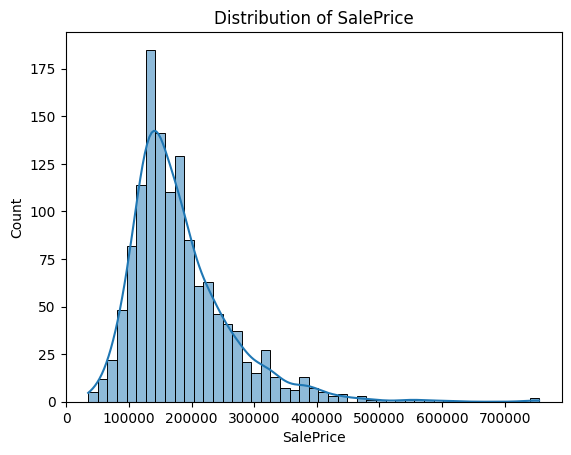

Skewness of SalePrice: 1.822889179265334


In [55]:
# Distribution of SalePrice
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train_df["SalePrice"], kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.show()

# Check skewness
print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

# Skewed data

In [57]:
# Select only numerical columns for correlation
numerical_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix = train_df[numerical_cols].corr()

# Top 10 features most correlated with SalePrice
top_corr_features = correlation_matrix["SalePrice"].sort_values(ascending=False).head(10)
print("Top 10 features most correlated with SalePrice:")
print(top_corr_features)

Top 10 features most correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.792970
GrLivArea       0.701286
GarageCars      0.643394
GarageArea      0.620225
TotalBsmtSF     0.617864
1stFlrSF        0.612692
FullBath        0.559718
TotRmsAbvGrd    0.529440
YearBuilt       0.528811
Name: SalePrice, dtype: float64


In [58]:
# Average SalePrice by Neighborhood
print(train_df.groupby("Neighborhood")["SalePrice"].mean().sort_values(ascending=False))

Neighborhood
NoRidge    330713.368421
NridgHt    321100.558824
StoneBr    310499.000000
Timber     244200.081081
Veenker    243250.000000
Somerst    226260.233766
ClearCr    221430.434783
Crawfor    210676.755102
CollgCr    196634.933333
Gilbert    195521.647059
Blmngtn    194912.750000
NWAmes     191298.467742
SawyerW    189106.803571
Mitchel    155738.318182
NAmes      146512.465000
SWISU      144686.260870
NPkVill    142694.444444
Blueste    137500.000000
Sawyer     135491.794118
Edwards    128724.673913
OldTown    128123.617647
BrkSide    124143.981481
BrDale     105309.090909
MeadowV    101021.428571
IDOTRR      97841.290323
Name: SalePrice, dtype: float64


In [60]:
# Percentage of missing values
missing_data = train_df.isnull().mean().sort_values(ascending=False)
print(missing_data[missing_data > 0])

PoolQC          0.994673
MiscFeature     0.961948
Alley           0.936073
Fence           0.810502
MasVnrType      0.593607
FireplaceQu     0.470320
LotFrontage     0.181887
GarageYrBlt     0.054033
GarageCond      0.054033
GarageType      0.054033
GarageFinish    0.054033
GarageQual      0.054033
BsmtFinType2    0.025114
BsmtExposure    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
MasVnrArea      0.005327
Electrical      0.000761
dtype: float64


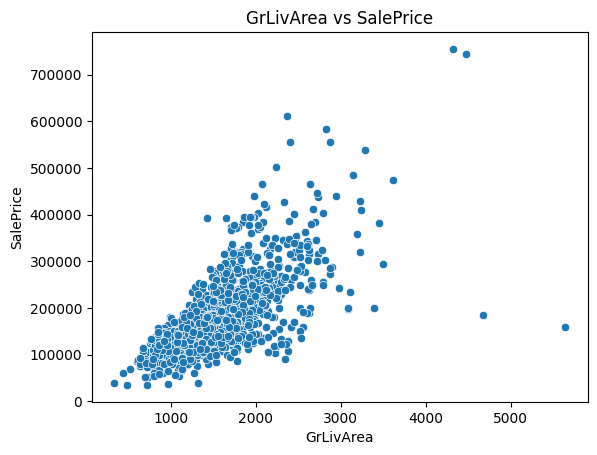

In [61]:
# Scatter plot for GrLivArea and SalePrice
sns.scatterplot(x=train_df["GrLivArea"], y=train_df["SalePrice"])
plt.title("GrLivArea vs SalePrice")
plt.show()

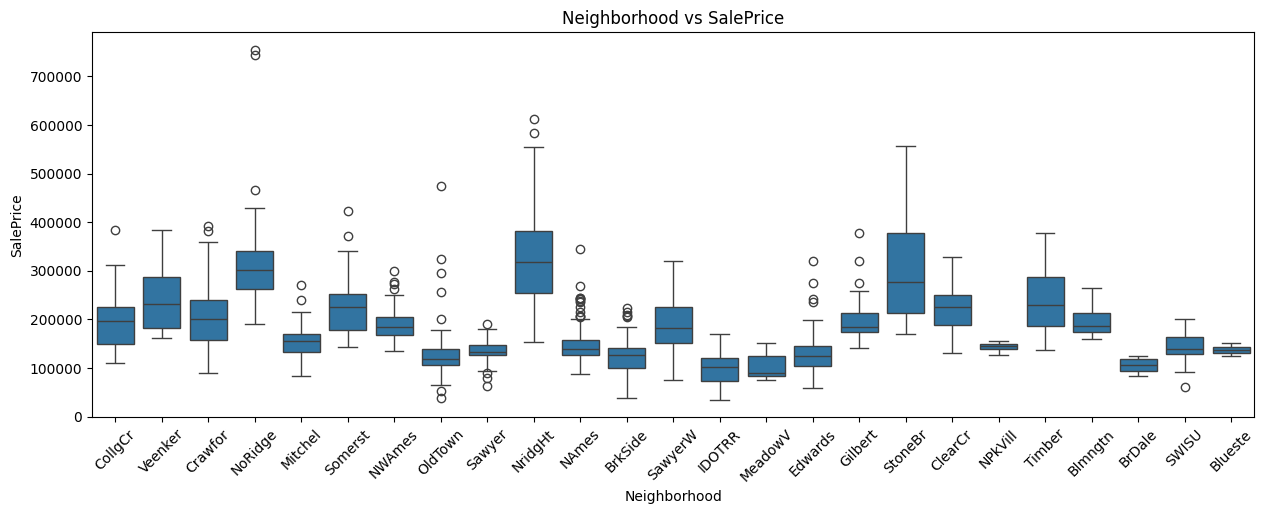

In [62]:
# Box plot for Neighborhood and SalePrice
plt.figure(figsize=(15, 5))
sns.boxplot(x=train_df["Neighborhood"], y=train_df["SalePrice"])
plt.title("Neighborhood vs SalePrice")
plt.xticks(rotation=45)
plt.show()

In [85]:
# import pandas as pd
# import numpy as np
# from sklearn.impute import SimpleImputer

# # Load datasets
# train_df = pd.read_csv("my_train.csv")
# validation_df = pd.read_csv("my_dev.csv")
# test_df = pd.read_csv("test.csv")

# # Separate features (X) and target (y)
# X_train = train_df.drop(columns=["Id", "SalePrice"])
# y_train = train_df["SalePrice"]

# X_dev = validation_df.drop(columns=["Id", "SalePrice"])
# y_dev = validation_df["SalePrice"]

# X_test = test_df.drop(columns=["Id"])

# # 1. Drop features with excessive missing data
# sparse_features = ["PoolQC", "MiscFeature", "Alley", "Fence"]
# X_train = X_train.drop(columns=sparse_features, errors="ignore")
# X_dev = X_dev.drop(columns=sparse_features, errors="ignore")
# X_test = X_test.drop(columns=sparse_features, errors="ignore")

# # 2. Impute moderate missing data for categorical features
# cat_features_to_impute_none = [
#     "MasVnrType", "FireplaceQu",
#     "GarageType", "GarageCond", "GarageFinish", "GarageQual",
#     "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"
# ]

# for col in cat_features_to_impute_none:
#     X_train[col] = X_train[col].fillna("None")
#     X_dev[col] = X_dev[col].fillna("None")
#     X_test[col] = X_test[col].fillna("None")

# # 3. Impute moderate missing data for numerical features
# num_features_to_impute_zero = ["GarageYrBlt", "MasVnrArea"]

# for col in num_features_to_impute_zero:
#     X_train[col] = X_train[col].fillna(0)
#     X_dev[col] = X_dev[col].fillna(0)
#     X_test[col] = X_test[col].fillna(0)

# # Impute LotFrontage with the median
# lot_frontage_imputer = SimpleImputer(strategy="median")
# X_train["LotFrontage"] = lot_frontage_imputer.fit_transform(X_train[["LotFrontage"]])
# X_dev["LotFrontage"] = lot_frontage_imputer.transform(X_dev[["LotFrontage"]])
# X_test["LotFrontage"] = lot_frontage_imputer.transform(X_test[["LotFrontage"]])

# # 4. Impute rare missing data
# # Impute Electrical with the mode
# electrical_mode = train_df["Electrical"].mode()[0]
# X_train["Electrical"] = X_train["Electrical"].fillna(electrical_mode)
# X_dev["Electrical"] = X_dev["Electrical"].fillna(electrical_mode)
# X_test["Electrical"] = X_test["Electrical"].fillna(electrical_mode)

# # Handle missing values in test set

# # Impute categorical columns with the mode
# categorical_cols = X_test.select_dtypes(include=["object"]).columns
# for col in categorical_cols:
#     X_test[col] = X_test[col].fillna(X_test[col].mode()[0])  # Use mode for categorical columns

# # Impute numerical columns with the median
# numerical_cols = X_test.select_dtypes(include=["int64", "float64"]).columns
# median_imputer = SimpleImputer(strategy="median")
# X_test[numerical_cols] = median_imputer.fit_transform(X_test[numerical_cols])  # Use median for numerical columns

# # Verify no missing values remain
# print("Missing values in test set after imputation:\n", X_test.isnull().sum().sum())


# # 5. Verify there are no missing values
# print("Missing values in training set:\n", X_train.isnull().sum().sum())
# print("Missing values in validation set:\n", X_dev.isnull().sum().sum())
# print("Missing values in test set:\n", X_test.isnull().sum().sum())

Missing values in test set after imputation:
 0
Missing values in training set:
 0
Missing values in validation set:
 0
Missing values in test set:
 0


In [92]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load datasets
train = pd.read_csv("my_train.csv")
dev = pd.read_csv("my_dev.csv")
test = pd.read_csv("test.csv")

# Separate features and target
X_train = train.drop(columns=["Id", "SalePrice"])
y_train = train["SalePrice"]
X_dev = dev.drop(columns=["Id", "SalePrice"])
y_dev = dev["SalePrice"]
X_test = test.drop(columns=["Id"])

# Feature Engineering
def feature_engineering(df):
    # Total Square Footage
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    
    # Total Bathrooms
    df["TotalBath"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
    
    # Room-to-Area Ratio
    df["RoomsPerArea"] = df["TotRmsAbvGrd"] / df["GrLivArea"]
    
    # Lot Frontage-to-Area Ratio
    df["FrontageRatio"] = df["LotFrontage"] / df["LotArea"]
    
    # Age of House
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    
    # Years Since Remodel
    df["YearsSinceRemodel"] = df["YrSold"] - df["YearRemodAdd"]
    
    # Interaction Features
    df["OverallQual*GrLivArea"] = df["OverallQual"] * df["GrLivArea"]
    df["YearBuilt*OverallCond"] = df["YearBuilt"] * df["OverallCond"]
    
    # Log Transformation for Skewed Features
    skewed_features = ["GrLivArea", "LotArea", "TotalBsmtSF", "TotalSF"]
    for feature in skewed_features:
        df[feature] = np.log1p(df[feature])
    
    return df

X_train = feature_engineering(X_train)
X_dev = feature_engineering(X_dev)
X_test = feature_engineering(X_test)

# Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=["object"]).columns
num_features = X_train.select_dtypes(exclude=["object"]).columns

# Preprocessing pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Ridge Regression pipeline
ridge_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("ridge", Ridge())
])

# Train Ridge Regression with GridSearchCV
ridge_param_grid = {"ridge__alpha": [0.1, 1, 10, 100, 200, 500]}
ridge_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring="neg_mean_squared_log_error")
ridge_search.fit(X_train, np.log(y_train))

# Best Ridge Model
best_ridge_model = ridge_search.best_estimator_
print(f"Best Ridge alpha: {ridge_search.best_params_['ridge__alpha']}")

# Evaluate Ridge Regression on Development Set
y_dev_log_pred = best_ridge_model.predict(X_dev)
y_dev_pred = np.exp(y_dev_log_pred)
rmsle_ridge = np.sqrt(mean_squared_log_error(y_dev, y_dev_pred))
print(f"RMSLE (Ridge): {rmsle_ridge}")

# Predict on Test Set
y_test_log_pred = best_ridge_model.predict(X_test)
y_test_pred = np.exp(y_test_log_pred)

# Save Predictions
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": y_test_pred})
submission.to_csv("submission_with_features.csv", index=False)
print("Submission file 'submission_with_features.csv' created.")

Best Ridge alpha: 10
RMSLE (Ridge): 0.11953790845602928
Submission file 'submission_with_features.csv' created.
